In [1]:
import pandas as pd
import fastai.text as ftxt
import sklearn.model_selection as skms
import numpy as np
import spacy as sp
import pickle
import os

In [2]:
#import torch

In [3]:
#torch.cuda.is_available()

In [4]:
#torch.__version__

In [5]:
path = os.getcwd()
path

'/media/rinnely/Archer/ENES/Stance/legal_abortion'

In [6]:
path = os.getcwd()
topic = 'la'
os.makedirs(path+'/NN/'+ topic, exist_ok=True)
path_nn_model= path+'/NN/'+topic
path_nn_model

'/media/rinnely/Archer/ENES/Stance/legal_abortion/NN/la'

In [7]:
tweets = pd.read_csv(path+'/alldatala.csv')

In [8]:
tweets.head()

,Unnamed: 0,Tweet,Stance
0,0,Just laid down the law on abortion in my bioet...,-1
1,1,@tooprettyclub Are you OK with #GOP males tell...,1
2,2,"If you don't want your kid, put it up for adop...",-1
3,3,"@RedAlert -there should be a ""stigma"" to butch...",-1
4,4,But isn't that the problem then. Not enough fa...,0


In [9]:
tweets = tweets[['Stance', 'Tweet']]

In [10]:
tweets.head()

,Stance,Tweet
0,-1,Just laid down the law on abortion in my bioet...
1,1,@tooprettyclub Are you OK with #GOP males tell...
2,-1,"If you don't want your kid, put it up for adop..."
3,-1,"@RedAlert -there should be a ""stigma"" to butch..."
4,0,But isn't that the problem then. Not enough fa...


In [11]:
tweets.Stance.unique()

array([-1,  1,  0])

In [12]:
tweets['Stance']=tweets.Stance.replace({'FAVOR':1, 'AGAINST':-1, 'NONE':0})

TypeError: Cannot compare types 'ndarray(dtype=int64)' and 'str'

In [13]:
train, test = skms.train_test_split(tweets, test_size=.50)

In [14]:
train.shape, test.shape

((2011, 2), (2011, 2))

In [15]:
train, test = skms.train_test_split(train, test_size=.30)

In [16]:
train.shape, test.shape

((1407, 2), (604, 2))

In [17]:
train.to_csv(path_nn_model+'/train_tweets2k70.csv', index=False)
test.to_csv(path_nn_model+'/test_tweets2k30.csv', index=False)

In [18]:
train = pd.read_csv(path_nn_model+'/train_tweets2k70.csv')
test = pd.read_csv(path_nn_model+'/test_tweets2k30.csv')

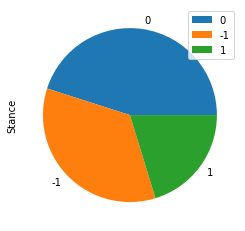

In [19]:
train['Stance'].value_counts().plot.pie(legend=True)

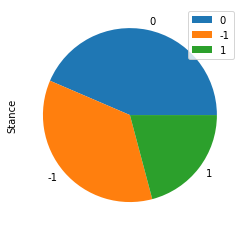

In [20]:
test['Stance'].value_counts().plot.pie(legend=True)

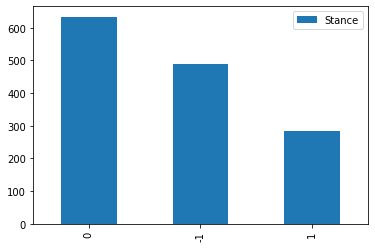

In [21]:
train['Stance'].value_counts().plot.bar(legend=True)

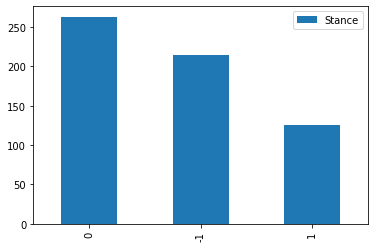

In [22]:
test['Stance'].value_counts().plot.bar(legend=True)

In [23]:
train

,Stance,Tweet
0,0,we can make this year and just about anything ...
1,0,Just been having rather horrible discussion wi...
2,-1,@zakzales @hillaryclinton omg! she and all oth...
3,-1,@newtowndoc thx for the follow! thank you for ...
4,1,we fixed the misleading @idc4ny mailer that cl...
...,...,...
1402,0,I wonder if America will like focus on real is...
1403,1,the pill cosby was garnished with empty pill c...
1404,-1,"“words kill, words give life; they’re either p..."
1405,-1,maratona trainspotting no cine praia grande! q...


In [24]:
data_lm = ftxt.TextLMDataBunch.from_df(path_nn_model, train, test, bs=32)
data_clas = ftxt.TextClasDataBunch.from_df(path_nn_model, train, test, vocab=data_lm.train_ds.vocab, bs=32)

In [25]:
data_lm.show_batch()

idx,text
0,life ! xxbos xxunk thx for the follow ! thank you for your holy work ! xxunk stand with you to save lives ! xxbos we fixed the misleading xxunk xxunk that claims xxunk members helped pass key legislation to xxunk . xxbos xxup rt xxunk : xxmaj the single most important xxunk for women 's xxunk in society is our ability to control our xxunk . xxbos i know
1,"kennedy will side with the liberals in giving xxunk 3 some xxunk xxbos first gay # muslim wedding takes place in the uk xxbos xxmaj damn , interesting news when you find out you were almost a xxunk of abortion xxbos just a few photos from our 2017 # marchforlife xxunk ! we are the # prolifegen xxunk xxbos rt if you agree with justice gorsuch on the role of"
2,"with their # 2 # scotus pick , meat xxunk . xxbos xxmaj it 's time to end the # deathpenalty in the xxmaj united xxmaj states . xxbos xxunk on the dance floor : is this guy xxunk you ? me : well , he 's my husband ... so yes xxbos # scotus is to xxunk , defend constitution , not social justice ! xxbos it 's hard"
3,"xxmaj if you 're all about equality , then the unborn babies get an equal chance at life too xxrep 4 . xxbos mt @amenditusa : new mood , new plan . let america decide ! xxbos "" we are not going back ! "" leader @andreascousins to xxunk xxunk xxbos along w / # scotus and xxunk of other judges and xxunk xxunk , this is why i voted"
4,"we do care about the hurt xxunk xxunk preborn children through . xxbos what do # reprorights look like in your state ? check out the new @naral report and find out ! xxbos instead of xxunk energy fighting , try xxunk a new xxunk that allows for other xxunk of view . then xxunk it like a fine xxunk . xxbos this is the rape xxunk who i serve"


In [26]:
data_clas.show_batch()

text,target
"xxbos xxunk xxunk xxunk xxunk # xxunk & & # xxunk knew the # aca , # xxunk , # scotus , # civilrights , # lgbtq & & women 's xxunk health was on the line & & they did n't care !",0
xxbos # xxup potus xxunk his legacy w / 1 / 2 xxunk wins . xxmaj the # xxup gop agenda ? xxup still ! ! xxmaj repeal # xxmaj gun laws & # xxmaj obamacare xxmaj ban xxmaj access 2,-1
"xxbos xxmaj xxunk , xxmaj xxunk , & xxmaj xxunk is always seen by the out - come . xxmaj the xxmaj xxunk xxmaj xxunk of xxmaj xxunk xxunk in all xxunk when it 's xxmaj fake xxmaj love .",0
"xxbos what # xxunk did to # xxunk is n't xxunk an xxunk event , but a # rapeculture ... it 's a way of life we must xxunk .. it starts with u & & me now !",1
"xxbos xxmaj the idea that a "" fetus "" is n't human is xxunk , i mean what else would it be ? a dog ? a xxunk ? xxmaj the unborn are xxup human xxup xxunk !",-1


In [27]:
data_lm.save(path_nn_model+'/data_lm.pkl')
data_clas.save(path_nn_model+'/data_clas.pkl')

In [28]:
data_lm.train_ds.vocab.itos[:10], len(data_lm.train_ds.vocab.itos)

(['xxunk',
  'xxpad',
  'xxbos',
  'xxeos',
  'xxfld',
  'xxmaj',
  'xxup',
  'xxrep',
  'xxwrep',
  '#'],
 1872)

In [29]:
learn = ftxt.language_model_learner(data_lm, arch=ftxt.AWD_LSTM, drop_mult=.2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.74E-01
Min loss divided by 10: 6.31E-02


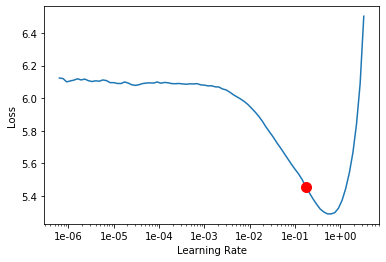

In [30]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [31]:
learn.fit_one_cycle(10,2e-01)

epoch,train_loss,valid_loss,accuracy,time
0,5.318258,4.442235,0.183854,00:02
1,4.636178,4.408869,0.229836,00:02
2,4.278842,4.833158,0.215551,00:02
3,4.107001,5.041933,0.214955,00:02
4,3.893212,5.178184,0.216295,00:02
5,3.620721,5.246179,0.210714,00:02
6,3.302583,5.355480,0.207589,00:02
7,2.981208,5.383151,0.217708,00:02
8,2.684442,5.381197,0.213170,00:02
9,2.453728,5.374971,0.212202,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.98E-02
Min loss divided by 10: 2.51E-02


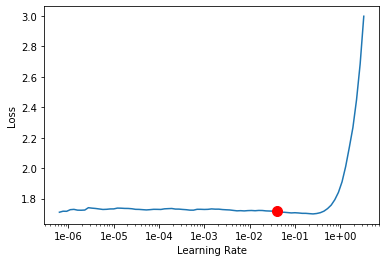

In [32]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [33]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.749213,5.377801,0.213988,00:02
1,1.754229,5.377835,0.213467,00:02
2,1.728905,5.374564,0.215402,00:02
3,1.717140,5.374359,0.215774,00:02
4,1.698118,5.378710,0.216592,00:02
5,1.679370,5.383806,0.217560,00:02
6,1.664574,5.389639,0.216890,00:02
7,1.656267,5.384370,0.218304,00:02
8,1.647622,5.393188,0.217783,00:02
9,1.638198,5.388560,0.217039,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 2.29E-06
Min loss divided by 10: 3.02E-02


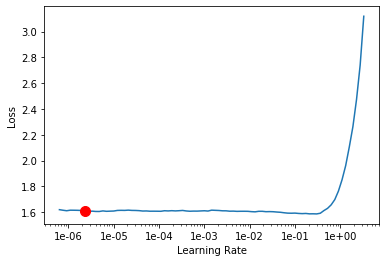

In [34]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [35]:
learn.fit_one_cycle(10)

epoch,train_loss,valid_loss,accuracy,time
0,1.621408,5.391630,0.218378,00:02
1,1.612528,5.392206,0.217634,00:02
2,1.606491,5.396402,0.217857,00:02
3,1.593095,5.402508,0.218155,00:02
4,1.586157,5.412788,0.218824,00:02
5,1.575366,5.426936,0.217113,00:02
6,1.562498,5.431976,0.217708,00:02
7,1.552045,5.430505,0.218452,00:02
8,1.546920,5.427715,0.218229,00:02
9,1.553147,5.429173,0.218527,00:02


In [36]:
learn.save_encoder(path_nn_model+'/ml_encoder2k')

In [37]:
learn.save('la-model2k')

In [38]:
learn = ftxt.text_classifier_learner(data_clas, ftxt.AWD_LSTM, drop_mult=0.5)

In [39]:
learn.load_encoder(path_nn_model+'/ml_encoder2k')
learn.metrics=[ftxt.accuracy, ftxt.FBeta(average='micro')]

In [40]:
learn.save('learner-1stage')

In [41]:
learn.load('learner-1stage');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.02E-02


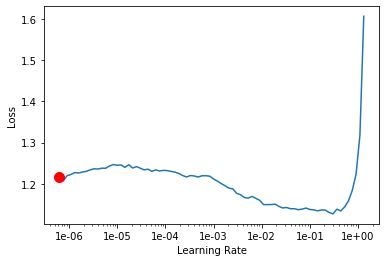

In [42]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [43]:
learn.fit_one_cycle(10,6.3e-07,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.217285,1.114825,0.360927,0.360927,00:02
1,1.200989,1.180342,0.329470,0.329470,00:02
2,1.207368,1.184158,0.346026,0.346027,00:02
3,1.199647,1.198313,0.312914,0.312914,00:02
4,1.192337,1.191263,0.317881,0.317881,00:02
5,1.205048,1.179416,0.337748,0.337748,00:02
6,1.207515,1.181145,0.317881,0.317881,00:02
7,1.204933,1.179888,0.332781,0.332781,00:02
8,1.212887,1.191080,0.317881,0.317881,00:02
9,1.201871,1.169141,0.336093,0.336093,00:02


In [44]:
learn.save('learner-2stage')

In [45]:
learn.load('learner-2stage');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.00E-02


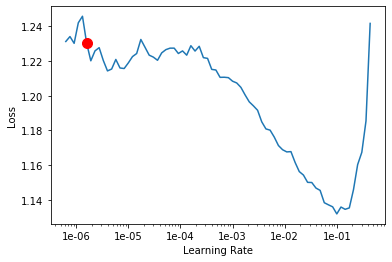

In [46]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [47]:
learn.fit_one_cycle(10,1.6e-06,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.206038,1.192348,0.334437,0.334437,00:02
1,1.207733,1.187216,0.317881,0.317881,00:02
2,1.213442,1.177805,0.336093,0.336093,00:02
3,1.193286,1.181322,0.321192,0.321192,00:02
4,1.186616,1.180404,0.331126,0.331126,00:02
5,1.191671,1.182151,0.326159,0.326159,00:02
6,1.195740,1.174831,0.337748,0.337748,00:02
7,1.200184,1.174115,0.339404,0.339404,00:02
8,1.200439,1.182537,0.337748,0.337748,00:02
9,1.201791,1.177341,0.326159,0.326159,00:02


In [48]:
learn.save('learner-stage')

In [49]:
learn.load('learner-stage');

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 6.31E-07
Min loss divided by 10: 3.98E-03


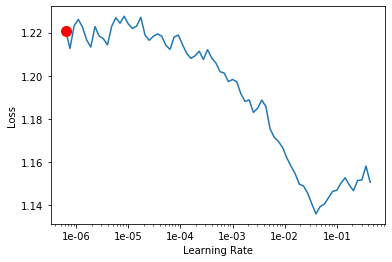

In [50]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [51]:
learn.fit_one_cycle(10,5e-02,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,1.051553,0.984680,0.496689,0.496689,00:02
1,0.986549,1.011440,0.526490,0.526490,00:02
2,0.958193,0.952242,0.534768,0.534768,00:02
3,0.942354,0.958676,0.538079,0.538080,00:02
4,0.926351,0.918678,0.544702,0.544702,00:02
5,0.903825,0.935955,0.577815,0.577815,00:02
6,0.878116,0.914948,0.561258,0.561258,00:02
7,0.857130,0.883294,0.572848,0.572848,00:02
8,0.841166,0.894995,0.566225,0.566225,00:02
9,0.819040,0.891760,0.576159,0.576159,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 4.79E-06
Min loss divided by 10: 6.31E-08


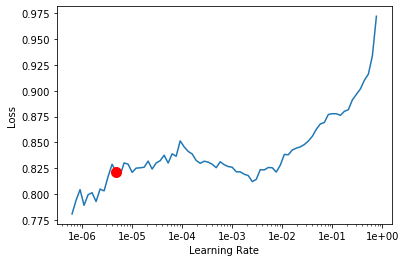

In [52]:
learn.freeze_to(-2)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [53]:
learn.fit_one_cycle(10,4.8e-06, moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.801898,0.892159,0.574503,0.574503,00:02
1,0.796332,0.889331,0.581126,0.581126,00:02
2,0.804554,0.899121,0.571192,0.571192,00:02
3,0.797035,0.890173,0.577815,0.577815,00:02
4,0.801599,0.891480,0.576159,0.576159,00:02
5,0.803682,0.890762,0.572848,0.572848,00:02
6,0.800003,0.886911,0.576159,0.576159,00:02
7,0.811761,0.890468,0.571192,0.571192,00:02
8,0.807388,0.891034,0.579470,0.579470,00:02
9,0.799538,0.893566,0.577815,0.577815,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.20E-05
Min loss divided by 10: 1.10E-05


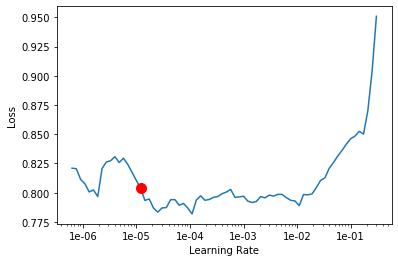

In [54]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [55]:
learn.fit_one_cycle(10,3e-05,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.806872,0.890544,0.564570,0.564570,00:02
1,0.807662,0.887918,0.584437,0.584437,00:02
2,0.797477,0.888973,0.581126,0.581126,00:02
3,0.793235,0.888685,0.579470,0.579470,00:02
4,0.786050,0.884431,0.591060,0.591060,00:02
5,0.792814,0.886038,0.582781,0.582781,00:02
6,0.792230,0.883334,0.586093,0.586093,00:02
7,0.775186,0.880623,0.584437,0.584437,00:02
8,0.780855,0.879575,0.587748,0.587748,00:02
9,0.794389,0.880599,0.589404,0.589404,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 7.59E-07
Min loss divided by 10: 3.31E-07


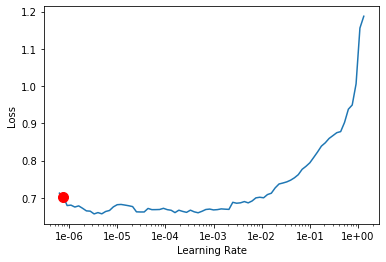

In [39]:
learn.freeze_to(-3)
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [56]:
learn.fit_one_cycle(10,7.7e-07,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.792540,0.880208,0.586093,0.586093,00:02
1,0.776967,0.879792,0.586093,0.586093,00:02
2,0.774423,0.880894,0.584437,0.584437,00:02
3,0.799276,0.881936,0.589404,0.589404,00:02
4,0.790353,0.883472,0.579470,0.579470,00:02
5,0.790096,0.876901,0.589404,0.589404,00:02
6,0.786518,0.882496,0.586093,0.586093,00:02
7,0.796608,0.881160,0.581126,0.581126,00:02
8,0.784334,0.880835,0.581126,0.581126,00:02
9,0.800543,0.881076,0.594371,0.594371,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.00E-05
Min loss divided by 10: 6.31E-08


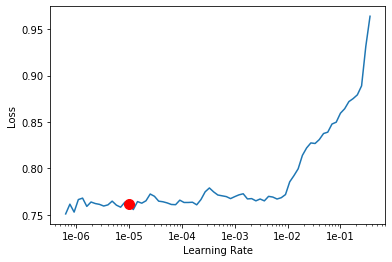

In [57]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [58]:
learn.fit_one_cycle(6,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.786537,0.871291,0.591060,0.591060,00:02
1,0.783793,0.865213,0.602649,0.602649,00:02
2,0.764983,0.859816,0.596026,0.596026,00:02
3,0.737157,0.848829,0.609272,0.609272,00:02
4,0.708679,0.840067,0.612583,0.612583,00:02
5,0.711804,0.842109,0.602649,0.602649,00:02


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


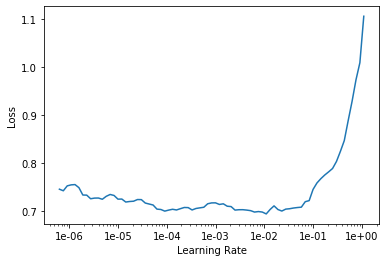

In [59]:
learn.unfreeze()
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [60]:
learn.fit_one_cycle(5, moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.692497,0.814213,0.614238,0.614238,00:04
1,0.640039,0.762184,0.663907,0.663907,00:04
2,0.575451,0.651645,0.708609,0.708609,00:04
3,0.488524,0.646444,0.716887,0.716887,00:04
4,0.429307,0.652933,0.720199,0.720199,00:05


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 3.63E-05
Min loss divided by 10: 6.31E-08


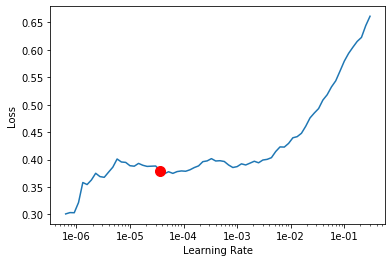

In [61]:
learn.lr_find(); learn.recorder.plot(suggestion=True)

In [62]:
learn.fit_one_cycle(5,moms=(0.7, 0.8))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.395960,0.639727,0.721854,0.721854,00:04
1,0.360194,0.660914,0.721854,0.721854,00:04
2,0.337421,0.645670,0.735099,0.735099,00:05
3,0.286264,0.626743,0.746689,0.746689,00:04
4,0.239835,0.648315,0.735099,0.735099,00:04


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


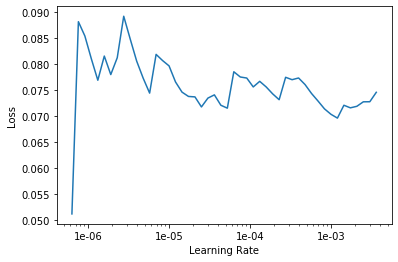

In [61]:
learn.lr_find(); learn.recorder.plot()

In [62]:
learn.fit_one_cycle(15,moms=(0.8, 0.7))

epoch,train_loss,valid_loss,accuracy,f_beta,time
0,0.073561,1.181819,0.626667,0.626667,00:04
1,0.086489,1.208847,0.640000,0.640000,00:04
2,0.076092,1.212426,0.620000,0.620000,00:01
3,0.076359,1.267633,0.613333,0.613333,00:01
4,0.077932,1.316755,0.593333,0.593333,00:01
5,0.074365,1.414496,0.600000,0.600000,00:01
6,0.072296,1.534045,0.593333,0.593333,00:01
7,0.069676,1.517587,0.573333,0.573333,00:01
8,0.070126,1.531858,0.586667,0.586667,00:01
9,0.069747,1.518744,0.586667,0.586667,00:01


In [63]:
preds, y, losses = learn.get_preds(with_loss=True)
interp = ftxt.TextClassificationInterpretation(learn, preds, y, losses)

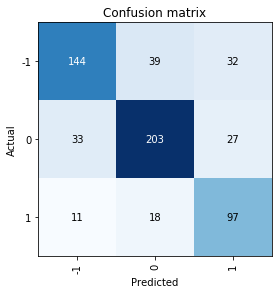

In [64]:
interp.plot_confusion_matrix()